In [1]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm
import copy
import matplotlib.pyplot as plt
from pde import MemoryStorage

from methods.base import BaseConfig
from methods.plotting import plot_perm, plot_press
from methods.pore_press_calc_functions import Pore_Press_Diffusion_with_Q_source, test_wells, applying_factors

In [2]:
# setup base params
base_params = BaseConfig(
            sources = [{'loc':(2000, 2000, 2000), 'Q':np.array([1, 1]), 'P': 0.2}, # P - target overpressue relative to P0 (if p0=0.1 MPa, P=-0.05 => abs pressure = 0.1 - 0.05 = 0.05 MPa)
                       {'loc':(500, 500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 3500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(500, 3500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},],
            time_scale=3600, 
            t_range=240,
            )

# wells testing if needed
# press_in_locs, interpolators = test_wells(copy.deepcopy(base_params))

In [3]:
from datetime import datetime
target_path = f'target_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5'

In [14]:
perms_path = 'downscaled_models_03_05_2024__13_33_23.h5'


with h5py.File(perms_path, 'r') as f:
    nmodels = f['perm'].shape[0]

# eq initial setup
eq = Pore_Press_Diffusion_with_Q_source(np.ones(base_params.shape), base_params)
p0 = eq.pore_ini_field

# idx_list = range(nmodels)
idx_list = [5,]
for ii in tqdm(idx_list):
    with h5py.File(perms_path, 'r') as f:
        perm = f['perm'][ii]
    
    eq.perm = perm # updating eq with new perm
    eq.xi_field = eq.get_xi_field()
    params = applying_factors(perm, copy.deepcopy(base_params))
    storage = MemoryStorage()
    res = eq.solve(p0, t_range=params.t_range, solver='scipy', tracker=[storage.tracker(1)])
    # res = eq.solve(p0, t_range=params.t_range, solver='scipy', tracker=['progress', 'plot', storage.tracker(1)])
    pore_press_list = storage.data # list of np arrays
    pore_press = np.stack(pore_press_list, axis=0) # 4d np array

  0%|          | 0/1 [00:00<?, ?it/s]

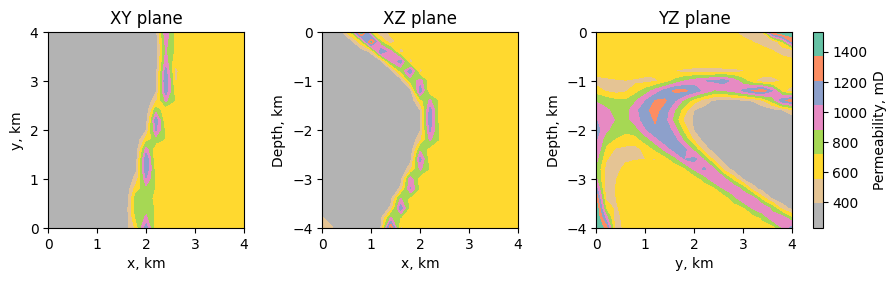

In [5]:
plot_perm(perm, (10, 10, 10), params)

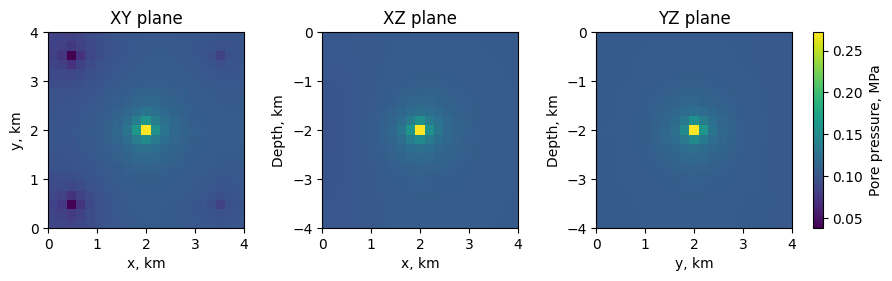

In [6]:
plot_press(pore_press[-1], (10, 10, 10), params)

In [7]:
# to event calc funcs

from scipy import stats

In [16]:
time_steps = pore_press.shape[0]
model_shape = pore_press.shape[1:]